# Notebook to calculate group differences based on paper drakesmith et al

This is the  multi-threshold permutation correction approach and consists:

1) Apply thresholds to networks and compute network metrics for all networks across all thresholds
2) Compute test statistics for each network
3) Permute across groups to get the null distrubition
4) Take the maximum test statistic across all thresholds for each permutation resulting in one summarised null statistic for each permutation. 
5) Identify the critical value for the test-statistic from the top αth percentile of the null test statistics, where α is the desired confidence level (e.g., 5%).
6) Identify clusters where the true test statistic is higher than the critical value and compute the AUC for these clusters.
 

In [1]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import functions.plotting_functions as Pfun
import functions.statistical_functions as Sfun
import seaborn as sns
sns.set_style('dark')
from decouple import config

data = config('data')

In [126]:
def pval_plotting(ctvalues:list, tcrit_value:int, measure:str, permutations:int, crit_val:int) -> None:
    
    '''
    Wrapper around seaborn displot.
    Function to plot null distribution with 2 std either side and true critical value.

    Parameters
    -----------------------------------------------------------------
    ctvalues : list, list of crticial values from the null distrubtion.
    tcrit_value: int True crtical value of a test.
    measure: str, name of the measure (used in title of the graph)
    permutations: int, number of permuations (used in title of the graph)


    Returns
    -----------------------------------------------------------------
    hist: histogram of null distribution with upper and lower std with
          true value.
    '''
    
    #Calculates the mean and std deviation of null distribution

    mean_val = Sfun.mean_std(ctvalues)
    
    #plots 
    hist = sns.displot(data=ctvalues, height=10).set(title=f'Histplot for {measure} after {permutations} permuatations')
    hist.refline(x=tcrit_value, color='purple')
    hist.refline(x=crit_val, color='green', linestyle='-')
    hist.refline(x=mean_val['lower_2std'], linestyle='-', color='black')
    hist.refline(x=mean_val['upper_2std'], linestyle='-', color='black')
    hist.refline(x=mean_val['lower_1std'], linestyle='-', color='red')
    hist.refline(x=mean_val['upper_1std'], linestyle='-', color='red')
    plt.show()

Import data.

In [2]:
lh_volume = pd.read_csv(f'{data}/lh_volume.dat',sep='\t').drop(['BrainSegVolNotVent', 'eTIV'],axis=1).rename(columns={'lh.aparc.volume':'G-Number'})
rh_volume =  pd.read_csv(f'{data}/rh_volume.dat',sep='\t').drop(['BrainSegVolNotVent', 'eTIV','rh.aparc.volume'],axis=1)

group = pd.read_csv(f'{data}/cortical_measures.csv').iloc[0:,2]

volume = pd.concat([lh_volume, rh_volume, group],axis=1)

names = list(volume.columns.drop(['G-Number','age_adjusted_group']))

centroids = pd.read_csv(f'{data}/atlas.csv')
centroids = centroids[['x.mni', 'y.mni', 'z.mni']].to_numpy()


group = volume.groupby('age_adjusted_group')
aan = group.get_group('AAN').reset_index(drop=True)
hc = group.get_group('HC').reset_index(drop=True)
wr = group.get_group('WR').reset_index(drop=True)

## 1) Apply thresholds to networks and compute network metrics for all networks across all thresholds

First the threshold range needs to be decided. To do this the methodology used is taken from Bassett et al (https://doi.org/10.1073/pnas.0606005103) where the upper limit must not exceed 2 * natural log(nodes). 
Starting point of 4 is used otherwise minimum spanning tree is too large and throws up error message.

Threshold values are stored in a list.

In [3]:
threshold_value=[]
for threshold in range(4 , 100):
    aan_graphs = Sfun.create_graphs(aan.iloc[:,1:69], names, centroids, threshold=threshold)
    aan_graphs['graph_threshold'].calculate_nodal_measures()
    cal = aan_graphs['graph_threshold'].report_nodal_measures()
    
    if cal['degree'].mean() > 2 * np.log(len(aan_graphs['graph_threshold'].nodes())):
        break
    
    threshold_value.append(threshold)

Now create graphs at the pre-defined thresholds.

In [4]:
result = {
    'aan_graphs':[],
    'hc_graphs':[],
    'wr_graphs':[]
}

In [5]:
for threshold in threshold_value:
    aan_graphs = Sfun.create_graphs(aan.iloc[:,1:69], names, centroids, threshold=threshold)
    aan_graphs['graph_threshold'].__name__ = f'aan_graph_threshold_value_{threshold}'
    result['aan_graphs'].append(aan_graphs['graph_threshold'])

    hc_graphs = Sfun.create_graphs(hc.iloc[:,1:69], names, centroids, threshold=threshold)
    hc_graphs['graph_threshold'].__name__ = f'hc_graph_threshold_value_{threshold}'
    result['hc_graphs'].append(hc_graphs['graph_threshold'])

    wr_graphs = Sfun.create_graphs(wr.iloc[:,1:69], names, centroids, threshold=threshold)
    wr_graphs['graph_threshold'].__name__ = f'wr_graph_threshold_value_{threshold}'
    result['wr_graphs'].append(wr_graphs['graph_threshold'])

Finally calculate global measures for each graph at the threshold ranges.

In [6]:
measures = {}

In [7]:
for keys, values in result.items():
    for graph_object in values:
        global_measures = graph_object.calculate_global_measures()
        measures[f'{graph_object.__name__}'] = []
        measures[f'{graph_object.__name__}'].append(global_measures)

## 2) Compute test statistics for each network

Calculate the test statistic for each condition. This is going to be the difference between each global measure for two groups. 

In [8]:
test_statistics = {
    'aan_hc':{},
    'wr_hc':{},
    'wr_aan':{}
}

In [9]:
for threshold in threshold_value:
    for keys, value in measures['aan_graph_threshold_value_4'][0].items():
        statistic_aan_hc =  measures[f'aan_graph_threshold_value_{threshold}'][0][keys] - measures[f'hc_graph_threshold_value_{threshold}'][0][keys]
        statistic_wr_hc =  measures[f'wr_graph_threshold_value_{threshold}'][0][keys] - measures[f'hc_graph_threshold_value_{threshold}'][0][keys]
        statistic_wr_aan =  measures[f'wr_graph_threshold_value_{threshold}'][0][keys] - measures[f'aan_graph_threshold_value_{threshold}'][0][keys]
        
        key = f'{keys}_at_threshold_value_{threshold}'
      
        test_statistics['aan_hc'][key] = statistic_aan_hc 
        test_statistics['wr_hc'][key] = statistic_wr_hc
        test_statistics['wr_aan'][key] = statistic_wr_aan

## 3) Permute across groups to get the null distrubition

Now we permutate to create a null distrubtion


In [10]:
#This is a useful function to get all the measures easily

def list_of_measures() -> list:
    '''
    Function to get list of graph measures

    Parameters
    ----------
    None

    Returns
    -------
    list: list of graph theory measures
    '''
    return ['average_clustering', 'average_shortest_path_length', 'assortativity', 'modularity', 'efficiency']

In [11]:
def permuations(permutations:int, length_of_group_1:int, length_of_group_2:int, participants:pd.DataFrame, names:list, centroids:np.float64, threshold:int) -> dict:
    measures = list_of_measures()
    null_distribution ={
        
        'average_clustering':[],
        'average_shortest_path_length':[], 
        'assortativity':[], 
        'modularity':[], 
        'efficiency':[]
    
    }
    
    for perm in range(permutations):
        group_1_participants = participants.sample(n=length_of_group_1)
        group_2_participants = participants.sample(n=length_of_group_2)
        
        group_1_graphs = Sfun.create_graphs(group_1_participants.iloc[:,1:69], names, centroids, threshold=threshold)
        group_2_graphs = Sfun.create_graphs(group_2_participants.iloc[:,1:69], names, centroids)
        
        group_1_values = group_1_graphs['graph_threshold'].calculate_global_measures()
        group_2_graphs = group_2_graphs['graph_threshold'].calculate_global_measures()
    
        for meas in measures:
            crit_val = group_1_values[meas] -  group_2_graphs[meas]
            null_distribution[meas].append(crit_val)
            
    return null_distribution

In [12]:
aan_hc_df = pd.concat([aan, hc], ignore_index=True)
aan_wr_df = pd.concat([wr, aan], ignore_index=True)
wr_hc_df = pd.concat([wr, hc], ignore_index=True)

null_distribution = {
    'aan_hc':{},
    'wr_hc':{},
    'wr_aan':{}
}

for threshold in threshold_value:
    aan_hc_perm = permuations(100, len(aan['G-Number']), len(hc['G-Number']), aan_hc_df, names, centroids, threshold)
    aan_wr_perm = permuations(100, len(aan['G-Number']), len(wr['G-Number']), aan_wr_df, names, centroids, threshold)
    wr_hc_perm = permuations(100, len(wr['G-Number']), len(hc['G-Number']), wr_hc_df, names, centroids, threshold)
    
    key = f'thresholded_value_{threshold}'
    null_distribution['aan_hc'][key] = aan_hc_perm 
    null_distribution['wr_hc'][key] = aan_wr_perm
    null_distribution['wr_aan'][key] = wr_hc_perm

import pickle

with open('permutations.pickle', 'wb') as handle:
    pickle.dump(null_distribution, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [13]:
import pickle

with open('permutations.pickle', 'rb') as handle:
    null_distribution = pickle.load(handle)

In [14]:
print(max(null_distribution['aan_hc']['thresholded_value_4']['average_shortest_path_length']))
print(test_statistics['aan_hc']['average_shortest_path_length_at_threshold_value_4'])

4.231782265144864
-0.08077260755048243


## 4) Take the maximum test statistic across all thresholds for each permutation resulting in one summarised null statistic for each permutation. 



In [15]:
def find_max_null_stat(null_distribution:dict, group_key:str, measure_key:str, list_number:int) -> int:
    
    '''
    Function to loop through each element in a list for each thresold value.

    Parameters
    ----------
    null_distribution:dict dictionary of null_distribution
    group_key:str dictionary key for group 
    measure_key:str dictionary key for the graph theory measure.
    list_number:int list index of permutation

    Returns
    -------
    max_null_statistic:int max null statistic for that permutation.

    '''
    
    values = []
    for threshold in threshold_value:
        values.append(null_distribution[group_key][f'thresholded_value_{threshold}'][measure_key][list_number])
    
    max_null_statistic = max(values, key=abs)
    return max_null_statistic

In [16]:
null_stat_summarized = {
    
    'aan_hc':{},
    'wr_hc':{},
    'wr_aan':{}
}


Once dictionary has been initialised it needs to be set up to be able to take the permutations and list.

In [17]:
measures = list_of_measures()

for measure in measures:
    null_stat_summarized['aan_hc'][measure] = []
    null_stat_summarized['wr_hc'][measure] = []
    null_stat_summarized['wr_aan'][measure] = [] 

In [18]:
for perm in range(0, 100):
    for measure in measures:
        aan_hc_max_null_statistic = find_max_null_stat(null_distribution, 'aan_hc', measure, perm )
        wr_hc_max_null_statistic = find_max_null_stat(null_distribution, 'wr_hc', measure, perm )
        wr_aan_max_null_statistic = find_max_null_stat(null_distribution, 'wr_aan', measure, perm )

        null_stat_summarized['aan_hc'][measure].append(aan_hc_max_null_statistic)
        null_stat_summarized['wr_hc'][measure].append(wr_hc_max_null_statistic)
        null_stat_summarized['wr_aan'][measure].append(wr_aan_max_null_statistic)


## 5) Identify the critical value for the test-statistic from the top αth percentile of the null test statistics, where α is the desired confidence level (e.g., 5%).

To take into account direction of effect the Max value is calculated at both ends of the distribution.   

In [160]:
crit_val = {}

In [161]:
for top_key in null_stat_summarized.keys():
    for measure in measures:
        crit_val[f'{top_key}_{measure}']= [np.quantile(np.array(null_stat_summarized[top_key][measure]), 0.05), 
                                           np.quantile(np.array(null_stat_summarized[top_key][measure]), 0.95)]
        

## 6) Identify clusters where the true test statistic is higher than the critical value and compute the AUC for these clusters.

This is done by checking that the statistic is greater than the max value on both ends of the distribution.

In [197]:
clusters ={}

for top_key in test_statistics.keys():
    for key , val in test_statistics[top_key].items():
        new_key = re.sub(r'_at_threshold_value_.*','', key)
        critical_value = crit_val[f'{top_key}_{new_key}']

        lower = val < critical_value[0]
        upper =  val > critical_value[1]
        direction = lambda lower, upper: 'lower' if lower ==True else 'upper'

        if lower or upper == True:
            clusters[f'{top_key}_{key}'] = {'direction':direction(lower, upper), 
                                            'value':test_statistics[top_key][key], 
                                            'null':null_stat_summarized[top_key][new_key]}

In [199]:
#clusters
#obsAUC = np.trapz(x=clusters['aan_hc_average_clustering_at_threshold_value_4']['null'], y=clusters['aan_hc_average_clustering_at_threshold_value_4']['value'])
#thresh_interp = np.linspace(start=np.min(1000), stop=np.max(1000), num=500)
#thresh_interp

IndexError: list assignment index out of range

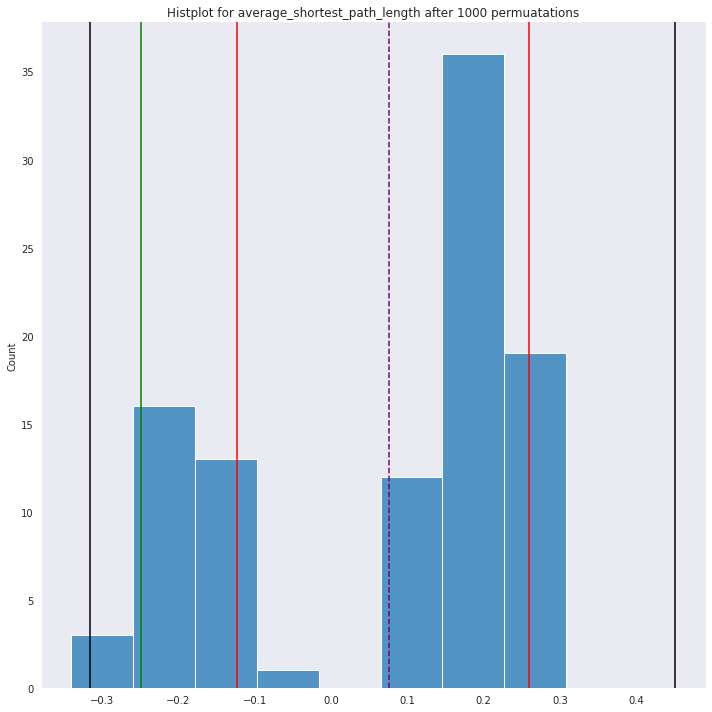

In [147]:
pval_plotting(null_stat_summarized['wr_aan']['assortativity'], test_statistics['wr_aan']['assortativity_at_threshold_value_4'], 'average_shortest_path_length', 1000, crit_val['wr_aan_assortativity'][0] )